In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.table import Table

In [2]:
import seaborn as sns

This notebook uses all the raw data from the XID+MIPS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources coming from two different surveys at different depths (SERVS and SWIRE) I will split the XID+ run into two different runs. Here we use the SERVS depth.

In [3]:
Sel_func=pymoc.MOC()
Sel_func.read('../data/ELAIS_N1/MOCs/holes_ELAIS-N1_irac1_O16_MOC.fits')
SERVS_MOC=pymoc.MOC()
SERVS_MOC.read('../data/ELAIS_N1/MOCs/DF-SERVS_ELAIS-N1_MOC.fits')
Final=Sel_func.intersection(SERVS_MOC)

## Read in XID+MIPS catalogue

In [4]:
XID_MIPS=Table.read('../data/ELAIS_N1/MIPS/dmu26_XID+MIPS_ELAIS-N1_SERVS_cat_20170710.fits')

In [5]:
XID_MIPS[0:10]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,
str100,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J161006.621+533656.872,242.527587012,53.6157979058,10.4667,22.6099,3.04599,-0.0133419,4.90328e-06,nan,2000.0,0.0
HELP_J161005.559+533642.824,242.523161793,53.6118954771,12.3774,25.8053,3.60663,-0.0133419,4.90328e-06,nan,2000.0,0.0
HELP_J161008.641+533615.951,242.536005913,53.6044309555,116.806,131.279,103.169,-0.0133419,4.90328e-06,nan,2000.0,0.0
HELP_J161002.817+533625.213,242.511735883,53.6070036615,70.9787,88.4681,52.4919,-0.0133419,4.90328e-06,nan,2000.0,0.0
HELP_J161009.708+533610.215,242.540451147,53.6028373869,132.994,146.192,120.556,-0.0133419,4.90328e-06,nan,2000.0,0.0
HELP_J161000.783+533454.820,242.503263565,53.5818943665,5.79204,13.5911,1.59307,-0.0133419,4.90328e-06,nan,2000.0,0.0
HELP_J161002.558+533606.162,242.510656314,53.6017117556,18.1655,31.734,6.73982,-0.0133419,4.90328e-06,nan,2000.0,0.0
HELP_J161005.420+533611.962,242.522583128,53.6033228215,12.266,24.3795,3.96191,-0.0133419,4.90328e-06,nan,2000.0,0.0


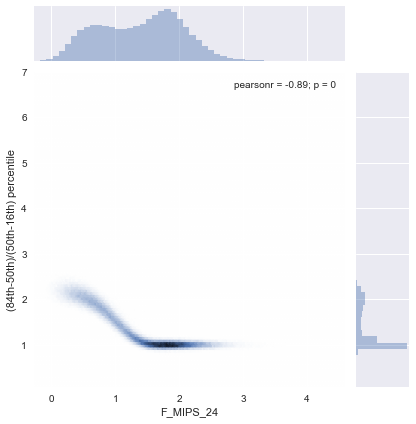

In [6]:
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24']),y=skew, kind='hex')


The uncertianties become Gaussian by $\sim 20 \mathrm{\mu Jy}$

In [7]:
good=XID_MIPS['F_MIPS_24']>20

In [8]:
good.sum()

120282

## Read in Maps

In [9]:

im100fits='../data/ELAIS_N1/PACS/ELAIS-N1-100um-img_wgls.fits'#PACS 100 map
nim100fits='../data/ELAIS_N1/PACS/ELAIS-N1-100um-img_noise.fits'#PACS 100 noise map
im160fits='../data/ELAIS_N1/PACS/ELAIS-N1-160um-img_wgls.fits'#PACS 160 map
nim160fits='../data/ELAIS_N1/PACS/ELAIS-N1-160um-img_noise.fits'#PACS 100 noise map
#output folder
output_folder='./'

In [10]:
from astropy.io import fits
from astropy import wcs

#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist[0].header
im100hdu=hdulist[0].header
im100=hdulist[0].data
w_100 = wcs.WCS(hdulist[0].header)
pixsize100=3600.0*np.abs(hdulist[0].header['CDELT1']) #pixel size (in arcseconds)
hdulist.close()

hdulist = fits.open(nim100fits)
nim100=hdulist[0].data
hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist[0].header
im160hdu=hdulist[0].header

im160=hdulist[0].data #convert to mJy
w_160 = wcs.WCS(hdulist[0].header)
pixsize160=3600.0*np.abs(hdulist[0].header['CDELT1']) #pixel size (in arcseconds)
hdulist.close()

hdulist = fits.open(nim160fits)
nim160=hdulist[0].data
hdulist.close()


## Read in PSF

In [11]:
pacs100_psf=fits.open('../../dmu18/dmu18_ELAIS-N1/dmu18_PACS_100_PSF_ELAIS-N1_20170720.fits')
pacs160_psf=fits.open('../../dmu18/dmu18_ELAIS-N1/dmu18_PACS_160_PSF_ELAIS-N1_20170720.fits')

centre100=np.long((pacs100_psf[1].header['NAXIS1']-1)/2)
radius100=15
centre160=np.long((pacs160_psf[1].header['NAXIS1']-1)/2)
radius160=25

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[1].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[1].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map




In [12]:
print(pind100)

[  0.           0.33333333   0.66666667   1.           1.33333333
   1.66666667   2.           2.33333333   2.66666667   3.           3.33333333
   3.66666667   4.           4.33333333   4.66666667   5.           5.33333333
   5.66666667   6.           6.33333333   6.66666667   7.           7.33333333
   7.66666667   8.           8.33333333   8.66666667   9.           9.33333333
   9.66666667  10.        ]


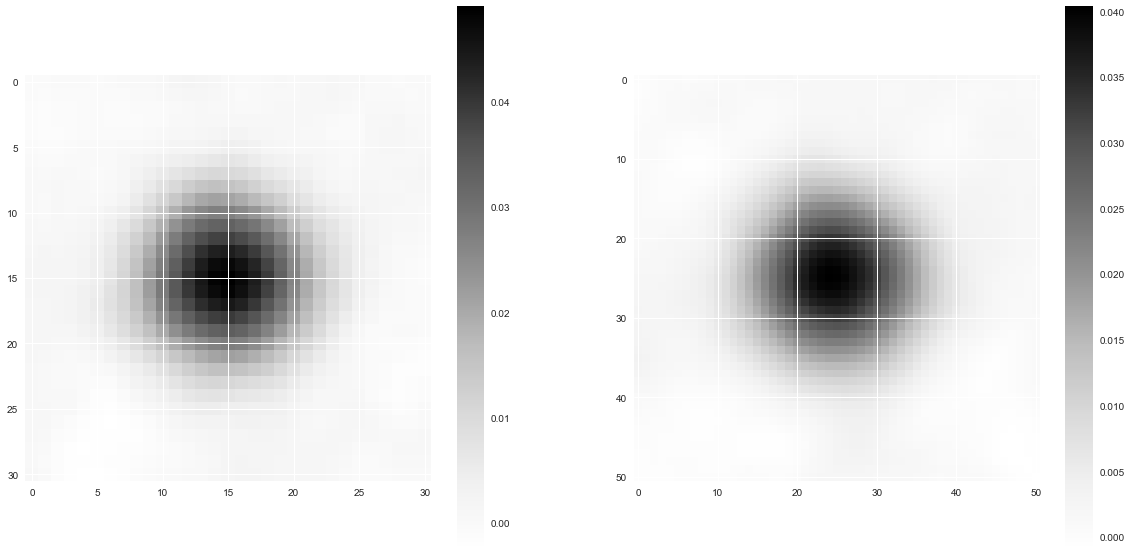

In [13]:
import pylab as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()


## Set XID+ prior class

In [14]:
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=Final)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_ELAIS-N1-SERVS.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=Final)
prior160.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_ELAIS-N1-SERVS.fits',ID=XID_MIPS['help_id'][good])
prior160.prior_bkg(0.0,5)


In [15]:
# Divide by 1000 so that units are mJy
prior100.set_prf(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [16]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior100.sra,prior100.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior100.sra,prior100.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./'
outfile=output_folder+'Master_prior.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior100,prior160],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 3362 tiles required for input catalogue and 9 large tiles


SystemExit: 